In [1]:
# notebooks/stock_analysis.ipynb

# Import system references
import sys
import os

# Ensure project_root is in the system path
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
#print("Project root added to sys.path:", project_root in sys.path)
#print(sys.path)



In [2]:
#setup Logging
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')



In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Import the fetch_stock_data function
from scripts import fetch_stock_data, transform_stock_data_to_delta, transform_with_history
from scripts import prepare_data_for_training, create_time_series_windows, lstm_model, prepare_sliding_window_data

In [4]:
# Ask the user for a ticker symbol
ticker = input("Please enter a stock ticker symbol (e.g., 'AAPL', 'SPY', 'QQQ', etc.): ").upper()

# Define start and end dates
start_date = '2021-01-01'

# If end_date is not provided, you can set it to today's date
end_date = datetime.today().strftime('%Y-%m-%d')  # Default to today's date if not specified

# Print the ticker and date range to confirm
print(f"Fetching data for {ticker} from {start_date} to {end_date}")


Fetching data for T from 2021-01-01 to 2024-10-29


In [5]:
# Fetch stock data
stock_data_df = fetch_stock_data(ticker, start_date, end_date)
#stock_data_df = fetch_stock_data(ticker, start_date)

# Check if data is fetched successfully
if not stock_data_df.empty:
    # Display the first few rows
    display(stock_data_df.head())
else:
    print("No data to display.")

2024-10-29 17:11:45,940 - INFO - End date provided: 2024-10-29
2024-10-29 17:11:45,941 - INFO - Fetching data for ticker: T from 2021-01-01 to 2024-10-29
2024-10-29 17:11:49,197 - INFO - Resetting index to make 'Date' a column.
2024-10-29 17:11:49,200 - INFO - Flattening multi-level column names (removing ticker symbol).
2024-10-29 17:11:49,201 - INFO - Successfully fetched and simplified data for ticker 'T'.


Price,Date,Adj Close,Close,High,Low,Open,Volume
0,2021-01-04 00:00:00+00:00,16.598408,22.235649,22.273415,21.918428,22.197886,86700816
1,2021-01-05 00:00:00+00:00,16.496925,22.099697,22.469790,22.046827,22.280968,83054520
2,2021-01-06 00:00:00+00:00,16.818291,22.530210,22.658609,22.182779,22.212992,73455520
3,2021-01-07 00:00:00+00:00,16.863396,22.590633,22.726585,22.416918,22.673716,71265359
4,2021-01-08 00:00:00+00:00,16.747099,21.918428,22.061934,21.714502,22.009064,72471656


In [6]:
# Transform Stock Data to Deltas
columns_to_exclude = ['Adj Close', 'High', 'Low']  # Drop 'Adj Close'
columns_to_keep = ['Volume']  # Keep 'Volume' but exclude from delta calculation
columns_to_calculate = ['Open', 'Close']  # Calculate deltas for 'Open' and 'Close'

transformed_data_df = transform_stock_data_to_delta(
    stock_data_df, 
    columns_to_exclude=columns_to_exclude, 
    columns_to_calculate=columns_to_calculate, 
    columns_to_keep=columns_to_keep
)

#transformed_data_df = transform_stock_data_to_delta(stock_data_df)
#transformed_data_df = transform_stock_data_to_delta(stock_data_df, exclude=['Volume'])

# Display Transformed Data
if not transformed_data_df.empty:
    display(transformed_data_df.head())
else:
    print("No transformed data to display.")


2024-10-29 17:11:49,223 - INFO - Starting transformation of stock data to deltas.
2024-10-29 17:11:49,224 - INFO - Dropping columns: ['Adj Close', 'High', 'Low']
2024-10-29 17:11:49,225 - INFO - Calculating deltas for specified columns: ['Open', 'Close']
2024-10-29 17:11:49,226 - INFO - Transforming column: Open
2024-10-29 17:11:49,228 - INFO - Transforming column: Close
2024-10-29 17:11:49,229 - INFO - Dropping the first row with NaN values after delta calculation.
2024-10-29 17:11:49,230 - INFO - Successfully transformed stock data to deltas.


Price,Date,Close,Open,Volume,Open_delta,Close_delta
1,2021-01-05 00:00:00+00:00,22.099697,22.280968,83054520,0.0037,-0.0061
2,2021-01-06 00:00:00+00:00,22.530210,22.212992,73455520,-0.0031,0.0195
3,2021-01-07 00:00:00+00:00,22.590633,22.673716,71265359,0.0207,0.0027
4,2021-01-08 00:00:00+00:00,21.918428,22.009064,72471656,-0.0293,-0.0298
5,2021-01-11 00:00:00+00:00,21.805136,21.706949,40833484,-0.0137,-0.0052


In [7]:
# Prepare the data by removing non-delta columns
delta_only_df = prepare_sliding_window_data(transformed_data_df)

# Display the first few rows of the resulting DataFrame
display(delta_only_df.head())


Price,Open_delta,Close_delta
1,0.0037,-0.0061
2,-0.0031,0.0195
3,0.0207,0.0027
4,-0.0293,-0.0298
5,-0.0137,-0.0052


In [8]:
# Define parameters
n_timesteps = 100  # Number of timesteps (sequence length)

# Step 1: Create the time series windows (X and y)
X, y = create_time_series_windows(delta_only_df, 'Close_delta', n_timesteps)

# Display the first few occurrences of the X and y arrays
print("First 5 entries of X:\n", X[:5])  # Display first 5 rows
print("First 5 entries of y:\n", y[:5])  # Display first 5 target values

# Step 2: Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Display the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


First 5 entries of X:
 [[[ 0.0037 -0.0061]
  [-0.0031  0.0195]
  [ 0.0207  0.0027]
  [-0.0293 -0.0298]
  [-0.0137 -0.0052]
  [ 0.0045 -0.0042]
  [-0.0028 -0.0049]
  [-0.0049  0.0238]
  [ 0.0105 -0.0041]
  [ 0.0114 -0.0075]
  [-0.0096  0.0003]
  [-0.0031 -0.0045]
  [-0.0035  0.0035]
  [-0.0017  0.0062]
  [ 0.0118  0.022 ]
  [-0.0021 -0.0205]
  [-0.0003 -0.0117]
  [-0.0086 -0.0059]
  [ 0.0056  0.0007]
  [-0.0055 -0.0038]
  [-0.0094 -0.0011]
  [ 0.0004  0.0133]
  [ 0.0161  0.0014]
  [-0.0003 -0.0055]
  [-0.0107 -0.0052]
  [-0.0007 -0.0024]
  [-0.0045  0.0049]
  [ 0.0032  0.0038]
  [ 0.007   0.0059]
  [ 0.0007  0.0207]
  [ 0.0253 -0.0115]
  [-0.0088 -0.0079]
  [-0.0102  0.011 ]
  [ 0.0228 -0.0048]
  [-0.0118  0.0069]
  [-0.0048 -0.0255]
  [-0.0165 -0.0258]
  [-0.0181  0.0072]
  [-0.0028  0.0046]
  [ 0.0036  0.0177]
  [ 0.0209  0.007 ]
  [ 0.0083  0.0242]
  [ 0.0183  0.0125]
  [ 0.0122 -0.0117]
  [ 0.0013  0.0118]
  [-0.001  -0.015 ]
  [-0.0003  0.0091]
  [ 0.004   0.004 ]
  [-0.009   0.002

In [9]:
# Initialize the scaler for X and y values
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reshape X data to 2D for scaling, keeping the last dimension as features
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  # Reshape to 2D: [samples * timesteps, features]
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Apply scaling to X features (fit on X_train, transform both X_train and X_test)
X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(n_samples_train, X_train.shape[1], X_train.shape[2])
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(n_samples_test, X_test.shape[1], X_test.shape[2])

# Reshape y values to 2D (required by MinMaxScaler)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Apply scaling to y values
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)



In [10]:
# Define parameters
#n_timesteps = 25
n_features = X_train_scaled.shape[2]

# Define the number of layers and units per layer
num_layers = 3
units_per_layer = [50, 100, 50]  # 3 layers with 50, 100, and 50 units, respectively

# Call the LSTM model
y_pred_scaled, history, model = lstm_model(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, n_timesteps, n_features, num_layers, units_per_layer, 
                         learning_rate=0.00001, epochs=70, batch_size=28)

# Extract the loss data from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


c:\Users\mark.storer\Documents\Data\AI\Repositories\Project_3a\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/70
25/25 - 7s - 262ms/step - loss: 0.3109 - val_loss: 0.3041
Epoch 2/70
25/25 - 2s - 88ms/step - loss: 0.3065 - val_loss: 0.2997
Epoch 3/70
25/25 - 3s - 107ms/step - loss: 0.3024 - val_loss: 0.2957
Epoch 4/70
25/25 - 2s - 98ms/step - loss: 0.2984 - val_loss: 0.2920
Epoch 5/70
25/25 - 3s - 105ms/step - loss: 0.2948 - val_loss: 0.2885
Epoch 6/70
25/25 - 3s - 105ms/step - loss: 0.2913 - val_loss: 0.2851
Epoch 7/70
25/25 - 3s - 114ms/step - loss: 0.2878 - val_loss: 0.2814
Epoch 8/70
25/25 - 3s - 105ms/step - loss: 0.2839 - val_loss: 0.2768
Epoch 9/70
25/25 - 3s - 110ms/step - loss: 0.2786 - val_loss: 0.2713
Epoch 10/70
25/25 - 3s - 132ms/step - loss: 0.2724 - val_loss: 0.2643
Epoch 11/70
25/25 - 3s - 138ms/step - loss: 0.2652 - val_loss: 0.2572
Epoch 12/70
25/25 - 3s - 135ms/step - loss: 0.2577 - val_loss: 0.2489
Epoch 13/70
25/25 - 3s - 135ms/step - loss: 0.2488 - val_loss: 0.2393
Epoch 14/70
25/25 - 4s - 153ms/step - loss: 0.2387 - val_loss: 0.2290
Epoch 15/70
25/25 - 4s - 142ms/

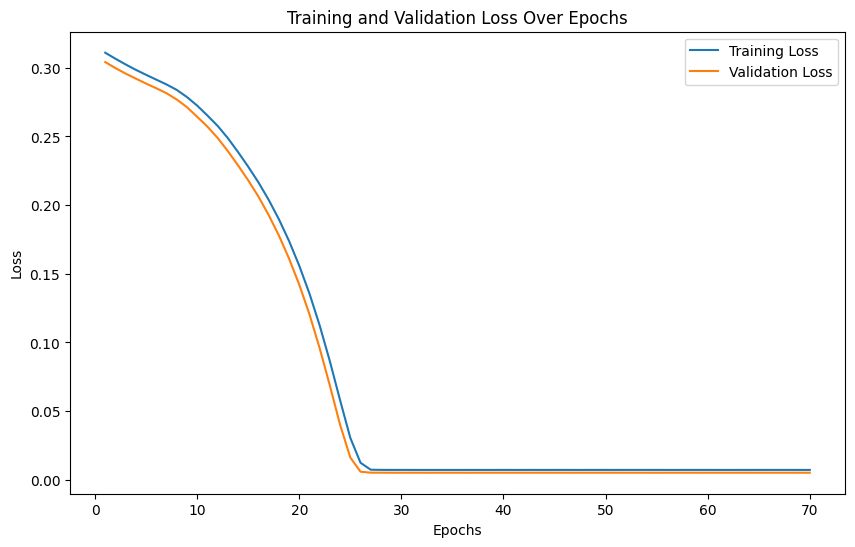

In [11]:
epochs = range(1, len(train_loss) + 1)
    
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(epochs, train_loss, label='Training Loss')

# Plot validation loss
plt.plot(epochs, val_loss, label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [12]:
# Step 1: Inverse transform the predicted and actual y values to the original scale
y_pred_original = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Display the first few occurrences of prediction and test scaled and unscaled arrays
print("First 5 entries of y_pred_scaled", y_pred_scaled[:5])  # Display first 5 rows
print("First 5 entries of y_pred_original", y_pred_original[:5])  # Display first 5 rows
print("First 5 entries of y_test_scaled", y_test_scaled[:5])  # Display first 5 target values
print("First 5 entries of y_test_original", y_test_original[:5])  # Display first 5 target values

# Mean Squared Error
mse = mean_squared_error(y_test_original, y_pred_original)
# Root Mean Squared Error
rmse = np.sqrt(mse)
# Mean Absolute Error
mae = mean_absolute_error(y_test_original, y_pred_original)
# R-squared
r2 = r2_score(y_test_original, y_pred_original)

# Print the metrics
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

First 5 entries of y_pred_scaled [[0.55308807]
 [0.55080247]
 [0.537435  ]
 [0.5410101 ]
 [0.57889074]]
First 5 entries of y_pred_original [[ 3.7833623e-04]
 [-5.3413558e-05]
 [-2.5785293e-03]
 [-1.9031955e-03]
 [ 5.2524609e-03]]
First 5 entries of y_test_scaled [[0.55690842]
 [0.75648491]
 [0.55108523]
 [0.66701959]
 [0.62625728]]
First 5 entries of y_test_original [[0.0011]
 [0.0388]
 [0.    ]
 [0.0219]
 [0.0142]]
Mean Squared Error (MSE): 0.000186
Root Mean Squared Error (RMSE): 0.013637
Mean Absolute Error (MAE): 0.010220
R-squared (R²): 0.028991


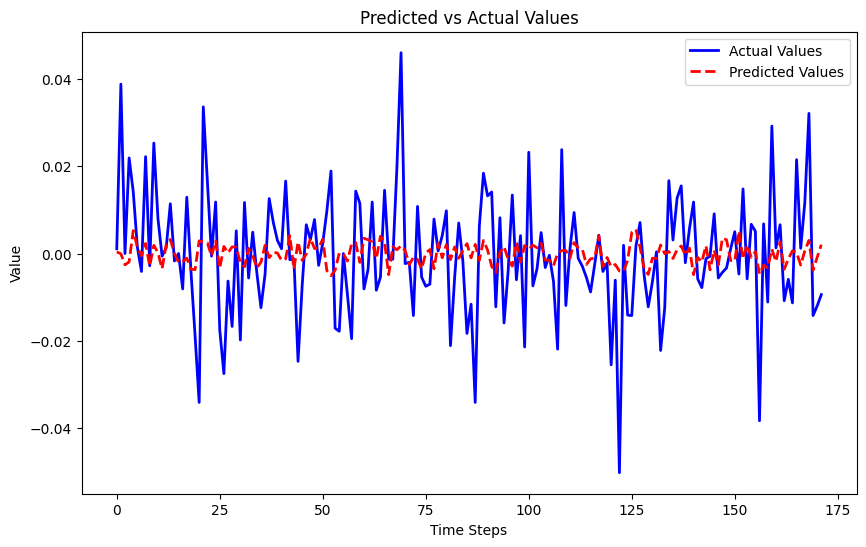

In [13]:
plt.figure(figsize=(10, 6))

plt.plot(y_test_original, label='Actual Values', color='blue', linewidth=2)
plt.plot(y_pred_original, label='Predicted Values', color='red', linestyle='--', linewidth=2)

plt.title('Predicted vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()

plt.show()

In [14]:
# Create a DataFrame to compare actual and predicted values
comparison_df = pd.DataFrame({'Actual': y_test_original.flatten(), 'Predicted': y_pred_original.flatten()})
# Calculate the difference (error)
comparison_df['Difference'] = comparison_df['Actual'] - comparison_df['Predicted']
#print(comparison_df.head(25))

In [15]:
# Get the sign of the actual and predicted values
actual_sign = np.sign(comparison_df['Actual'])
predicted_sign = np.sign(comparison_df['Predicted'])
#print(actual_sign.head(25))
#print(predicted_sign.head(25))
# Check where the signs match
sign_matches = actual_sign == predicted_sign
#print(sign_matches.head(25))

# Calculate the percentage of sign matches
percentage_match = sign_matches.mean() * 100

print(f"Percentage of Sign Matches: {percentage_match :.2f}%")

Percentage of Sign Matches: 55.81%


In [16]:
# Get the prediction for tomorrow's Close_delta

"""
Predict the next Close_delta based on the most recent n_timesteps of data.
    
Using:
- model: The trained LSTM model.
- delta_only_df (pd.DataFrame): The DataFrame containing all historical data, including the latest Close_delta.
- n_timesteps (int): The number of timesteps (sequence length) used in the model.
- scaler_X: The scaler used to scale the features (X).
- scaler_y: The scaler used to scale the target (y).

Returns:
- float: The predicted Close_delta for the next day.
"""
# Step 1: Extract the last n_timesteps rows from the data (to be used as input for prediction)
last_window = delta_only_df[-n_timesteps:].values.reshape(1, n_timesteps, delta_only_df.shape[1])

# Step 2: Scale the input features
last_window_scaled = scaler_X.transform(last_window.reshape(-1, last_window.shape[-1])).reshape(1, n_timesteps, -1)

# Step 3: Use the model to predict the next Close_delta (scaled)
predicted_close_delta_scaled = model.predict(last_window_scaled)

# Step 4: Inverse transform the prediction to get the original scale of Close_delta
predicted_close_delta = scaler_y.inverse_transform(predicted_close_delta_scaled)

predicted_close_delta = predicted_close_delta[0][0]  # Return the predicted value

# Decision logic: Buy if positive, Sell if negative
if predicted_close_delta > 0:
    print(f"Predicted Close increase for {ticker} tomorrow is {(predicted_close_delta * 100):.2f}%. Suggestion: BUY with {percentage_match :.2f}% confidence")
else:
    print(f"Predicted Close decrease for {ticker} tomorrow is {(predicted_close_delta * 100):.2f}%. Suggestion: SELL with {percentage_match :.2f}% confidence")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Predicted Close increase for T tomorrow is 0.14%. Suggestion: BUY with 55.81% confidence
